In [ ]:
! gdown <id>

Здесь представлена попытка решения задачи сопоставления описания игры множеству тегов. Примеры с обученными моделями не внушили уверенности что такую задачу можно решать с помощью них. Вместо этого рассмотрим алгоритм:

1. Токенам из нормализованного описания игры сопоставлять теги
2. Парам токенов из нормализованного описания игры сопоставлять теги
3. Выбранным тегам сопоставлять связанные с ними теги

Сопоставление токена/пары токенов/тега тегу происходит через подсчет совпадений и несовпадений в конкретных играх в обучающей выборке. Далее варьируя параметры:

1. Нижняя граница кол-ва совпадений
2. Процент игр с совпадением токена/пары токенов/тега с тегом среди всех игр содержащих заданный токен/пару токенов/тег в обучающей выборке.

выберем оптимальные параметры и оценим модель.

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_json('/content/games_metadata.json')

In [ ]:
df_additional_tags = df[df['description'] == ''][['app_id', 'tags']].copy()

In [ ]:
df = df[df['description'] != ''].copy()

In [ ]:
len(df)

39346

In [ ]:
len(df_additional_tags)

8972

In [ ]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.3 MB/s eta 0:00:00


Лемматизация и разбиение описания игры на токены

In [ ]:
from catboost.text_processing import Tokenizer
import nltk
import os

nltk_data_path = os.path.join(os.path.dirname(nltk.__file__), 'nltk_data')
nltk.data.path.append(nltk_data_path)
nltk.download('wordnet', nltk_data_path)

[nltk_data] Downloading package wordnet to
[nltk_data]     /usr/local/lib/python3.10/dist-
[nltk_data]     packages/nltk/nltk_data...


True

In [ ]:
def prepare_description(row):

    description = row['description']

    tokenizer = Tokenizer(
                lowercasing=True,
                separator_type='BySense',
                token_types=['Word', 'Number']
                )

    stop_words = set(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"])

    def filter_stop_words(tokens):
        return list(filter(lambda x: x not in stop_words, tokens))

    lemmatizer = nltk.stem.WordNetLemmatizer()

    def lemmatize_tokens_nltk(tokens):
        return list(map(lambda t: lemmatizer.lemmatize(t), tokens))

    description = lemmatize_tokens_nltk(filter_stop_words(tokenizer.tokenize(description)))

    return description

In [ ]:
df['description_lemmatized'] = df.apply(prepare_description,axis=1)

Разбиение токенизированного описания игры на пары токенов

In [ ]:
def lemmatized_description_paired(row):

  description = row['description_lemmatized']
  prev = ''
  token_pair_list = []
  for lemma in description:
    if prev != '':
      token_pair_list.append(prev + ' ' + lemma)
    prev = lemma

  return token_pair_list

In [ ]:
df['description_lemmatized_paired'] = df.apply(lemmatized_description_paired, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
! pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26771 sha256=3d917c691fbf1a9d90b2a3e205a22f23a95dc687e6931e2ee3aecb4ab7aa71fe
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [ ]:
! pip install SQLAlchemy==1.4.17

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 49.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for SQLAlchemy: filename=SQLAlchemy-1.4.17-cp310-cp310-linux_x86_64.whl size=1535533 sha256=77574cbe7ae333aa80803410beefce7bcc8c2f062d4dbf7cbe8fbec10745971d
  Stored in directory: /root/.cache/pip/wheels/eb/d0/1e/ab0fcbac6f74a69b788a37fccd365fc67535b5ab79f97bd860
Successfully built SQLAlchemy
  Attempting uninstall: SQLAlchemy
    Found existing installation: SQLAlchemy 2.0.16
    Uninstalling SQLAlchemy-2.0.16:
      Successfully uninstalled SQLAlchemy-2.0.16


In [ ]:
from pandasql import sqldf
from sqlalchemy import text as sqlalchemy_text

In [ ]:
import time

https://github.com/catboost/catboost/blob/master/catboost/tutorials/events/2020_06_04_catboost_tutorial/text_features.ipynb

Здесь описан самопальный алгоритм кросс валидации. Датасет разбивается на N частей, из них N-1 будут обучающей выборкой а оставшаяся - тестовой. На обучающей выборке будет работать сбор данных как описано в алгоритме. На тестовой выборке будем смотреть совпадения/несовпадения по предсказанным тегам.
Всего будет N итераций в каждой из которых какая то часть датасета будет тестовой.

In [ ]:
def cv(df, # исходный датасет
       folds, # кол-во частей в разбиении исходного датасета
       tag_tag_1x1_match_cnt, # нижняя граница кол-ва совпадений в соответствиях тегов друг другу
       tag_tag_1x1_match_ratio, # нижняя граница процента совпадений среди общего множества в соответствиях тегов друг другу
       token_tag_2x1_match_cnt, # нижняя граница кол-ва совпадений в соответствиях пары токенов тегу
       token_tag_2x1_match_ratio, # нижняя граница процента совпадений среди общего множества в соответствиях пары токенов тегу
       token_tag_match_cnt, # нижняя граница кол-ва совпадений в соответствиях токена тегу
       token_tag_match_ratio, # нижняя граница процента совпадений среди общего множества в соответствиях токена тегу
       token_tag_stat_list = None, # подготовленные заданее данные по соответствию токена тегу
       token_tag_2x1_stat_list = None, # подготовленные заданее данные по соответствию пары токенов тегу
       tag_pairs_stat_list = None, # подготовленные заданее данные по соответствию тега тегу
       dump_match_data = True, # сохраняем ли при работе дампы данных по соответствиям
       prepared_df_folds = None, # принимаем ли на вход список уже разбитых на фолды данных датасета
       save_result = False # сохраняем ли результат работы по предложению тегов по описанию
       ):

  # по полученным на вход параметрам ограничиваем соответствия
  def prepare_search_sets(data,match_cnt,match_ratio):

    search_set = {}
    for row in list(data.values):
      if row[2] > match_cnt and row[4] > match_ratio:
        if row[0] not in search_set:
          search_set[row[0]] = {}
        search_set[row[0]][row[1]] = 1
    return search_set

  # по полученным на вход соответствиям предлагаем какие теги могли бы подойти
  def search_tags(row, **kwargs):

    tag_tag_1x1_search = kwargs['tag_tag_1x1_search']
    token_tag_2x1_search = kwargs['token_tag_2x1_search']
    token_tag_search = kwargs['token_tag_search']
    description = row['description_lemmatized']
    description_paired = row['description_lemmatized_paired']

    tags = set()
    res = set()

    for token in description:
      if token in token_tag_search:
        for tag in token_tag_search[token]:
          tags.add(tag)
          res.add(tag)

    for token in description_paired:
      if token in token_tag_2x1_search:
        for tag in token_tag_2x1_search[token]:
          tags.add(tag)
          res.add(tag)

    for tag in tags:
      if tag in tag_tag_1x1_search:
        for tag in tag_tag_1x1_search[tag]:
          res.add(tag)

    return list(res)

  if token_tag_stat_list is None:
    token_tag_stat_list = []

  if token_tag_2x1_stat_list is None:
    token_tag_2x1_stat_list = []

  if tag_pairs_stat_list is None:
    tag_pairs_stat_list = []

  res = []

  # разбиваем исходный датасет на части
  if prepared_df_folds == None:
    train = df.copy()
    parts_list = []
    for split_iter in range(folds - 1):
      split_ratio = (len(df)/folds) / len(train)
      train, test = train_test_split(train,test_size=split_ratio,random_state=42)
      parts_list.append(test)
    parts_list.append(train)
  else:
    parts_list = prepared_df_folds

  if save_result == True:
    result_tags = []

  # для каждой итерации подготавливаем test из одной части и train из остальных
  for iter in range(folds):
    print(f'cv iter={iter} started')
    iter_start = time.time()
    if prepared_df_folds == None:
      test = parts_list[iter].copy()
      train = pd.DataFrame()
      for part_id in range(len(parts_list)):
        if part_id != iter:
          if len(train.values) > 0:
            train = pd.concat([train, parts_list[part_id]]).copy()
          else:
            train = parts_list[part_id].copy()
    else:
      test = prepared_df_folds[iter][0]
      train = prepared_df_folds[iter][1]

    # составляем всевозможные соответствия токена тегу, собираем по ним статистику
    if len(token_tag_stat_list) != folds:
      tag_token_pairs = train[['app_id','tags','description_lemmatized']].explode('tags').explode('description_lemmatized').copy()
      tag_token_pairs.columns = ['app_id', 'tag', 'token']
      tag_token_pairs = tag_token_pairs.groupby(['tag','token'])['app_id'].agg('count').reset_index().copy() # nunique???
      tag_token_pairs.columns = ['tag', 'token','app_count']
      print(f'len tag_token_pairs = {len(tag_token_pairs)}')
      tag_token_pairs = tag_token_pairs[tag_token_pairs['app_count'] >= 10]
      print(f'len tag_token_pairs = {len(tag_token_pairs)}')
      tag_count = str(tag_token_pairs['tag'].nunique())
      print(f'tag_token_pairs tag count = {tag_count}')
      token_count = str(tag_token_pairs['token'].nunique())
      print(f'tag_token_pairs token count = {token_count}')
      app_tokens = train[['app_id','description_lemmatized']].explode('description_lemmatized').copy()
      app_tokens.columns = ['app_id', 'token']
      print(f'len app_tokens = {len(app_tokens)}')
      token_count = str(app_tokens['token'].nunique())
      print(f'app_tokens token count = {token_count}')
      app_tags = train[['app_id','tags']].explode('tags').copy()
      app_tags.columns = ['app_id', 'tag']
      df_additional_tags_exploded = df_additional_tags.explode('tags').copy()
      app_tags = pd.concat([app_tags, df_additional_tags_exploded]).copy()
      print(f'len app_tags = {len(app_tags)}')
      tag_count = str(app_tags['tag'].nunique())
      print(f'app_tags tag count = {tag_count}')
      start = time.time()
      q = 'select token, tag, match_cnt, not_match_cnt, \
                       cast(match_cnt * 1. / (match_cnt + not_match_cnt) as numeric(18,2)) as match_ratio \
                  from \
                      ( \
                        select ttp.token, ttp.tag, \
                               sum(case when tt2.app_id is not null then 1 else 0 end) match_cnt,\
                               sum(case when tt2.app_id is null then 1 else 0 end) not_match_cnt \
                          from app_tokens tt1 \
                               join tag_token_pairs ttp on tt1.token = ttp.token \
                               left join app_tags tt2 on tt2.tag = ttp.tag and tt1.app_id = tt2.app_id \
                         group by ttp.token, ttp.tag \
                       ) t \
                 where match_cnt > 1 \
                   and match_cnt * 1. / (match_cnt + not_match_cnt) > 0.1 \
                   '
      token_tag_stat = pd.DataFrame(sqldf(q, locals()))
      end = time.time()
      token_tag_stat_list.append(token_tag_stat)
      if dump_match_data:
        token_tag_stat.to_csv(f'/content/token_tag_stat_{iter}.csv')
      print(f'token tag match took {str(end - start)}')
    else:
      token_tag_stat = token_tag_stat_list[iter]
      print(f'token_tag_stat taken from reuse list in {iter} iteration')

    # составляем всевозможные соответствия пар токенов тегу, собираем по ним статистику
    if len(token_tag_2x1_stat_list) != folds:
      tag_token_1x2_pairs = train[['app_id','tags','description_lemmatized_paired']].explode('tags').explode('description_lemmatized_paired').copy()
      tag_token_1x2_pairs.columns = ['app_id', 'tag', 'token_pair']
      tag_token_1x2_pairs = tag_token_1x2_pairs.groupby(['tag','token_pair'])['app_id'].agg('count').reset_index().copy()  # nunique???
      tag_token_1x2_pairs.columns = ['tag', 'token_pair','app_count']
      print(f'len tag_token_1x2_pairs = {len(tag_token_1x2_pairs)}')
      tag_token_1x2_pairs = tag_token_1x2_pairs[tag_token_1x2_pairs['app_count'] >= 10]
      print(f'len tag_token_1x2_pairs = {len(tag_token_1x2_pairs)}')
      tag_count = str(tag_token_1x2_pairs['tag'].nunique())
      print(f'tag_token_1x2_pairs tag count = {tag_count}')
      token_count = str(tag_token_1x2_pairs['token_pair'].nunique())
      print(f'tag_token_1x2_pairs token count = {token_count}')
      app_token_pairs = train[['app_id','description_lemmatized_paired']].explode('description_lemmatized_paired').copy()
      app_token_pairs.columns = ['app_id', 'token_pair']
      print(f'len app_token_pairs = {len(app_token_pairs)}')
      start = time.time()
      q = 'select token_pair, tag, match_cnt, not_match_cnt, \
                    cast(match_cnt * 1. / (match_cnt + not_match_cnt) as numeric(18,2)) as match_ratio \
                    from  \
                    ( \
                     select ttp.token_pair, ttp.tag, \
                            sum(case when tt2.app_id is not null then 1 else 0 end) match_cnt, \
                            sum(case when tt2.app_id is null then 1 else 0 end) not_match_cnt \
                       from app_token_pairs tt1 \
                            join tag_token_1x2_pairs ttp on tt1.token_pair = ttp.token_pair \
                            left join app_tags tt2 on tt2.tag = ttp.tag and tt1.app_id = tt2.app_id \
                      group by ttp.token_pair, ttp.tag \
                    ) t \
                 where match_cnt > 1 \
                   and cast(match_cnt * 1. / (match_cnt + not_match_cnt) as numeric(18,2)) > 0.1 \
                   '
      token_tag_2x1_stat = pd.DataFrame(sqldf(q, locals()))
      end = time.time()
      token_tag_2x1_stat_list.append(token_tag_2x1_stat)
      if dump_match_data:
        token_tag_2x1_stat.to_csv(f'/content/token_tag_2x1_stat_{iter}.csv')
      print(f'token pair tag match took {str(end - start)}')
    else:
      token_tag_2x1_stat = token_tag_2x1_stat_list[iter]
      print(f'token_tag_2x1_stat taken from reuse list in {iter} iteration')

    # составляем всевозможные соответствия тегов тегам, собираем по ним статистику
    if len(tag_pairs_stat_list) != folds:
      tag_pairs = train[['app_id','tags', 'tags']].copy()
      df_additional_paired_tags = df_additional_tags[['app_id','tags', 'tags']]
      tag_pairs = pd.concat([tag_pairs, df_additional_paired_tags]).copy()
      tag_pairs.columns = ['app_id','tag1', 'tag2']
      tag_pairs = tag_pairs.explode('tag1').explode('tag2')
      tag_pairs = tag_pairs.groupby(['tag1','tag2'])['app_id'].agg('count').reset_index().copy()
      tag_pairs.columns = ['tag1', 'tag2','app_count']
      print(f'len tag_pairs = {len(tag_pairs)}')
      tag_pairs = tag_pairs[tag_pairs['tag1'] != tag_pairs['tag2']].copy()
      print(f'len tag_pairs = {len(tag_pairs)}')
      tag_pairs = tag_pairs[tag_pairs['app_count'] > 10].copy()
      print(f'len tag_pairs = {len(tag_pairs)}')
      start = time.time()
      q = 'select tag1, tag2, \
             match_cnt, not_match_cnt,  \
             cast(match_cnt * 1. / (match_cnt + not_match_cnt) as numeric(18,2)) as match_ratio \
             from  \
             ( \
             select ptp.tag1, ptp.tag2, \
                    sum(case when gti2.app_id is not null then 1 else 0 end) match_cnt, \
                    sum(case when gti2.app_id is null then 1 else 0 end) not_match_cnt \
               from app_tags gti1  \
                    join tag_pairs ptp on gti1.tag = ptp.tag1 \
                    left join app_tags gti2 on ptp.tag2 = gti2.tag and gti1.app_id = gti2.app_id \
              group by ptp.tag1, ptp.tag2 \
             ) t \
             where match_cnt > 1 \
               and cast(match_cnt * 1. / (match_cnt + not_match_cnt) as numeric(18,2)) > 0.1 \
               '
      tag_pairs_stat = pd.DataFrame(sqldf(q, locals()))
      end = time.time()
      tag_pairs_stat_list.append(tag_pairs_stat)
      if dump_match_data:
        tag_pairs_stat.to_csv(f'/content/tag_pairs_stat_{iter}.csv')
      print(f'tag tag match took {str(end - start)}')
    else:
      tag_pairs_stat = tag_pairs_stat_list[iter]
      print(f'tag_pairs_stat taken from reuse list in {iter} iteration')

    # исходя из поданных на вход параметров - ограничений , ограничиваем составленные соответствия
    # формируя при этом множества для поиска
    tag_tag_1x1_search = prepare_search_sets(tag_pairs_stat,
                                             tag_tag_1x1_match_cnt,
                                             tag_tag_1x1_match_ratio)
    token_tag_2x1_search = prepare_search_sets(token_tag_2x1_stat,
                                               token_tag_2x1_match_cnt,
                                               token_tag_2x1_match_ratio)
    token_tag_search = prepare_search_sets(token_tag_stat,
                                           token_tag_match_cnt,
                                           token_tag_match_ratio)
    # пробегаемся по токенам и парам токенов описания игры
    # ищем есть ли совпадения в множествах поиска, если есть выдаем соответствующшие теги
    test['pred_tags'] = test.apply(search_tags,
                                   tag_tag_1x1_search=tag_tag_1x1_search,
                                   token_tag_2x1_search=token_tag_2x1_search,
                                   token_tag_search=token_tag_search,
                                   axis=1)

    # вычисляем промежуточные метрики
    test['tp'] = [len(set(pred_tags).intersection(set(tags)))
    for (pred_tags, tags) in list(test[['pred_tags','tags']].values)]

    test['fp'] = [len(set(pred_tags) - set(tags))
    for (pred_tags, tags) in list(test[['pred_tags','tags']].values)]

    test['fn'] = [len(set(tags) - set(pred_tags))
    for (pred_tags, tags) in list(test[['pred_tags','tags']].values)]

    # сколько тегов предложила модель
    test['pred_len'] = [len(pred_tag_list)
    for pred_tag_list in list(test['pred_tags'].values)]

    # сохраняем в датасет предложенные, ошибочно предложенные и не предложенные теги
    if save_result == True:
      test['tp_tags'] = [list(set(pred_tags).intersection(set(tags)))
      for (pred_tags, tags) in list(test[['pred_tags','tags']].values)]

      test['fp_tags'] = [list(set(pred_tags) - set(tags))
      for (pred_tags, tags) in list(test[['pred_tags','tags']].values)]

      test['fn_tags'] = [list(set(tags) - set(pred_tags))
      for (pred_tags, tags) in list(test[['pred_tags','tags']].values)]

      result_tags.append(test[['app_id', 'tp_tags', 'fp_tags', 'fn_tags']])

    # вычисляем промежуточные метрики
    tp_sum = test['tp'].sum()
    fp_sum = test['fp'].sum()
    fn_sum = test['fn'].sum()

    tp_mean = test['tp'].mean()
    fp_mean = test['fp'].mean()
    fn_mean = test['fn'].mean()
    pred_len_mean = test['pred_len'].mean()

    # метрики итерации кросс валидации сохраняем в структуру
    res.append((iter,
                tag_tag_1x1_match_cnt,
                tag_tag_1x1_match_ratio,
                token_tag_2x1_match_cnt,
                token_tag_2x1_match_ratio,
                token_tag_match_cnt,
                token_tag_match_ratio,
                tp_sum,
                fp_sum,
                fn_sum,
                tp_mean,
                fp_mean,
                fn_mean,
                pred_len_mean))

    iter_end = time.time()

    print(f'{iter} learn iteration took {str(iter_end - iter_start)}')

  # возвращаем либо метрики на итерациях кросс валидации и сформированные множества соответствий
  # либо метрики на итерациях кросс валидации и сформированный результат
  if save_result == False:
    return (res, token_tag_stat_list, token_tag_2x1_stat_list, tag_pairs_stat_list)
  else:
    return (res, result_tags)

In [ ]:
# Запуск кросс валидации на сетке параметров

add_res = [] # результат

n_folds = 5 # кол-во частей на которые будет разбит результирующий датасет

read_match_data_from_dump = 1 # флаг чтения данных о соответствиях из плоского дампа
# сначала запускаем одну итерацию с read_match_data_from_dump = 0, формируется дамп
# потом на сетке параметров запускаем с read_match_data_from_dump = 1
# чтобы каждый раз не формировать одни и те же множества соответствий и выиграть время

# формируем заранее множества train и test из заданного датасета
# чтобы выиграть время при запуске на сетке параметров
train = df.copy()
parts_list = []
for split_iter in range(n_folds - 1):
  split_ratio = (len(df)/n_folds) / len(train)
  train, test = train_test_split(train,test_size=split_ratio,random_state=42)
  parts_list.append(test)
parts_list.append(train)

# формируем заранее множества train и test из заданного датасета
# чтобы выиграть время при запуске на сетке параметров
folds = []
for iter in range(len(parts_list)):
  test = parts_list[iter].copy()
  train = pd.DataFrame()
  for part_id in range(len(parts_list)):
    if part_id != iter:
      if len(train.values) > 0:
        train = pd.concat([train, parts_list[part_id]]).copy()
      else:
        train = parts_list[part_id].copy()
  folds.append((test,train))

del parts_list

# чтение данных о соответствиях из плоского дампа
if read_match_data_from_dump == 1:
  token_tag_stat_list = [pd.read_csv(f'/content/token_tag_stat_{iter}.csv',
                                     names = ['token',	'tag',	'match_cnt',	'not_match_cnt',	'match_ratio'],
                                     header=0)
                        for iter in range(n_folds)]
  token_tag_2x1_stat_list = [pd.read_csv(f'/content/token_tag_2x1_stat_{iter}.csv',
                                         names = ['token_pair', 'tag', 'match_cnt', 'not_match_cnt', 'match_ratio'],
                                         header=0)
                            for iter in range(n_folds)]
  tag_pairs_stat_list = [pd.read_csv(f'/content/tag_pairs_stat_{iter}.csv',
                                     names = ['tag1', 'tag2', 'match_cnt', 'not_match_cnt', 'match_ratio'],
                                     header=0)
                        for iter in range(n_folds)]

# сетка параметров, для всех значений из сетки будет запущена кросс валидация и
# ... и будут собраны метрики
parameter_grid = [
    (i, j, k, l, m, p)
    for i in [0.3, 0.4, 0.5, 0.6]
    for j in [10, 1000, 5000]
    for k in [0.3, 0.4, 0.5, 0.6]
    for l in [10, 1000, 5000]
    for m in [0.3, 0.4, 0.5, 0.6]
    for p in [10, 1000, 5000]
]

# Запуск кросс валидации на сетке параметров
for i, parameters in enumerate(parameter_grid):

  tag_tag_1x1_match_cnt = parameters[1]
  tag_tag_1x1_match_ratio = parameters[0]
  token_tag_2x1_match_cnt = parameters[3]
  token_tag_2x1_match_ratio = parameters[2]
  token_tag_match_cnt = parameters[5]
  token_tag_match_ratio = parameters[4]

  # первая итерация должна отработать честно чтобы сдампить данные о соответствиях
  if i == 0 and read_match_data_from_dump == 0:
    res, token_tag_stat_list, token_tag_2x1_stat_list, tag_pairs_stat_list = \
    cv(df,
       folds=n_folds,
       tag_tag_1x1_match_cnt = tag_tag_1x1_match_cnt,
       tag_tag_1x1_match_ratio = tag_tag_1x1_match_ratio,
       token_tag_2x1_match_cnt = token_tag_2x1_match_cnt,
       token_tag_2x1_match_ratio = token_tag_2x1_match_ratio,
       token_tag_match_cnt = token_tag_match_cnt,
       token_tag_match_ratio = token_tag_match_ratio,
       dump_match_data = True,
       prepared_df_folds = folds,
       save_result = False
       )
  else:
    # дальше готовые данные о соответствиях для каждой итерации передаются по ссылке
    res, token_tag_stat_list, token_tag_2x1_stat_list, tag_pairs_stat_list = \
    cv(df,
       folds=n_folds,
       tag_tag_1x1_match_cnt = tag_tag_1x1_match_cnt,
       tag_tag_1x1_match_ratio = tag_tag_1x1_match_ratio,
       token_tag_2x1_match_cnt = token_tag_2x1_match_cnt,
       token_tag_2x1_match_ratio = token_tag_2x1_match_ratio,
       token_tag_match_cnt = token_tag_match_cnt,
       token_tag_match_ratio = token_tag_match_ratio,
       token_tag_stat_list = token_tag_stat_list,
       token_tag_2x1_stat_list = token_tag_2x1_stat_list,
       tag_pairs_stat_list = tag_pairs_stat_list,
       dump_match_data = False,
       prepared_df_folds = folds,
       save_result = False
       )

  add_res += res

  print(f'add_res len = {len(add_res)}')

Статистика работы кросс валидации

In [ ]:
cv_results = pd.DataFrame(add_res)

In [ ]:
cv_results.columns = ['iter',
                      'tag_tag_1x1_match_cnt',
                      'tag_tag_1x1_match_ratio',
                      'token_tag_2x1_match_cnt',
                      'token_tag_2x1_match_ratio',
                      'token_tag_match_cnt',
                      'token_tag_match_ratio',
                      'tp_sum',
                      'fp_sum',
                      'fn_sum',
                      'tp_mean',
                      'fp_mean',
                      'fn_mean',
                      'pred_len_mean']

In [ ]:
cv_results

,iter,tag_tag_1x1_match_cnt,tag_tag_1x1_match_ratio,token_tag_2x1_match_cnt,token_tag_2x1_match_ratio,token_tag_match_cnt,token_tag_match_ratio,tp_sum,fp_sum,fn_sum,tp_mean,fp_mean,fn_mean,pred_len_mean
0,0,10,0.3,10,0.3,10,0.3,62956,184129,43828,7.999492,23.396315,5.568996,31.395807
1,1,10,0.3,10,0.3,10,0.3,62899,184592,42618,7.992249,23.455146,5.415248,31.447395
2,2,10,0.3,10,0.3,10,0.3,62872,183166,43221,7.988818,23.273952,5.491868,31.262770
3,3,10,0.3,10,0.3,10,0.3,62372,182971,43701,7.925286,23.249174,5.552859,31.174460
4,4,10,0.3,10,0.3,10,0.3,62867,185675,43210,7.992245,23.604755,5.493262,31.597000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,0,5000,0.6,5000,0.6,5000,0.6,1988,994,104796,0.252605,0.126302,13.315883,0.378907
8636,1,5000,0.6,5000,0.6,5000,0.6,2047,1030,103470,0.260102,0.130877,13.147395,0.390978
8637,2,5000,0.6,5000,0.6,5000,0.6,1931,1052,104162,0.245362,0.133672,13.235324,0.379034
8638,3,5000,0.6,5000,0.6,5000,0.6,1993,977,104080,0.253240,0.124142,13.224905,0.377382


Вычисляем нашу главную метрику по которой оценим работу модели на каждом множестве параметров. Это некий аналог f1. Посчитаем кол-во тегов которые мы угадали правильно (tp_sum), которые предложили ошибочно(fp_sum) и которые не нашли(fn_sum). На основе этого рассчитаем среднее гармоническое аналогов precision и recall

In [ ]:
cv_results['f1_analog'] = 2. / ( 1. / (cv_results['tp_sum'] / (cv_results['tp_sum'] + cv_results['fp_sum']) ) + 1. / (cv_results['tp_sum'] / (cv_results['tp_sum'] + cv_results['fn_sum'])))

In [ ]:
cv_results

,iter,tag_tag_1x1_match_cnt,tag_tag_1x1_match_ratio,token_tag_2x1_match_cnt,token_tag_2x1_match_ratio,token_tag_match_cnt,token_tag_match_ratio,tp_sum,fp_sum,fn_sum,tp_mean,fp_mean,fn_mean,pred_len_mean,f1_analog
0,0,10,0.3,10,0.3,10,0.3,62956,184129,43828,7.999492,23.396315,5.568996,31.395807,0.355815
1,1,10,0.3,10,0.3,10,0.3,62899,184592,42618,7.992249,23.455146,5.415248,31.447395,0.356360
2,2,10,0.3,10,0.3,10,0.3,62872,183166,43221,7.988818,23.273952,5.491868,31.262770,0.357094
3,3,10,0.3,10,0.3,10,0.3,62372,182971,43701,7.925286,23.249174,5.552859,31.174460,0.354975
4,4,10,0.3,10,0.3,10,0.3,62867,185675,43210,7.992245,23.604755,5.493262,31.597000,0.354561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,0,5000,0.6,5000,0.6,5000,0.6,1988,994,104796,0.252605,0.126302,13.315883,0.378907,0.036223
8636,1,5000,0.6,5000,0.6,5000,0.6,2047,1030,103470,0.260102,0.130877,13.147395,0.390978,0.037700
8637,2,5000,0.6,5000,0.6,5000,0.6,1931,1052,104162,0.245362,0.133672,13.235324,0.379034,0.035407
8638,3,5000,0.6,5000,0.6,5000,0.6,1993,977,104080,0.253240,0.124142,13.224905,0.377382,0.036554


In [ ]:
cv_results.to_csv('/content/cv_results.csv')

In [ ]:
cv_results = pd.read_csv('/content/cv_results.csv',
                         names = ['iter',
                                  'tag_tag_1x1_match_cnt',
                                  'tag_tag_1x1_match_ratio',
                                  'token_tag_2x1_match_cnt',
                                  'token_tag_2x1_match_ratio',
                                  'token_tag_match_cnt',
                                  'token_tag_match_ratio',
                                  'tp_sum',
                                  'fp_sum',
                                  'fn_sum',
                                  'tp_mean',
                                  'fp_mean',
                                  'fn_mean',
                                  'pred_len_mean',
                                  'f1_analog'],
                         header=0)

In [ ]:
cv_results.sort_values(by='f1_analog', ascending=False)

,iter,tag_tag_1x1_match_cnt,tag_tag_1x1_match_ratio,token_tag_2x1_match_cnt,token_tag_2x1_match_ratio,token_tag_match_cnt,token_tag_match_ratio,tp_sum,fp_sum,fn_sum,tp_mean,fp_mean,fn_mean,pred_len_mean,f1_analog
7216,1,1000,0.6,10,0.3,10,0.4,46377,63783,59140,5.892884,8.104574,7.514612,13.997459,0.430060
5776,1,5000,0.5,10,0.3,10,0.4,46202,63182,59315,5.870648,8.028208,7.536849,13.898856,0.429984
7936,1,5000,0.6,10,0.3,10,0.4,46201,63180,59316,5.870521,8.027954,7.536976,13.898475,0.429981
6496,1,10,0.6,10,0.3,10,0.4,46484,64237,59033,5.906480,8.162262,7.501017,14.068742,0.429934
5056,1,1000,0.5,10,0.3,10,0.4,46531,64429,58986,5.912452,8.186658,7.495044,14.099111,0.429893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8577,2,5000,0.6,1000,0.6,5000,0.6,1931,1052,104162,0.245362,0.133672,13.235324,0.379034,0.035407
7677,2,1000,0.6,1000,0.5,5000,0.6,1931,1052,104162,0.245362,0.133672,13.235324,0.379034,0.035407
7917,2,1000,0.6,5000,0.6,5000,0.6,1931,1052,104162,0.245362,0.133672,13.235324,0.379034,0.035407
7737,2,1000,0.6,5000,0.5,5000,0.6,1931,1052,104162,0.245362,0.133672,13.235324,0.379034,0.035407


Сгруппируем данные внутри итераций кросс валиадции на каждом множестве параметров

In [ ]:
cv_results_grouped = \
cv_results.groupby(['tag_tag_1x1_match_cnt',
                    'tag_tag_1x1_match_ratio',
                    'token_tag_2x1_match_cnt',
                    'token_tag_2x1_match_ratio',
                    'token_tag_match_cnt',
                    'token_tag_match_ratio']).agg({'tp_sum':['min','max','mean'],
                                                   'fp_sum':['min','max','mean'],
                                                   'fn_sum':['min','max','mean'],
                                                   'tp_mean':['min','max','mean'],
                                                   'fp_mean':['min','max','mean'],
                                                   'fn_mean':['min','max','mean'],
                                                   'pred_len_mean':['min','max','mean'],
                                                   'f1_analog':['min','max','mean']}
                                                  ).reset_index().copy()

In [ ]:
cv_results_grouped

tag_tag_1x1_match_cnt tag_tag_1x1_match_ratio token_tag_2x1_match_cnt  \
                                                                             
0                       10                     0.3                      10   
1                       10                     0.3                      10   
2                       10                     0.3                      10   
3                       10                     0.3                      10   
4                       10                     0.3                      10   
...                    ...                     ...                     ...   
1723                  5000                     0.6                    5000   
1724                  5000                     0.6                    5000   
1725                  5000                     0.6                    5000   
1726                  5000                     0.6                    5000   
1727                  5000                     0.6                    5000   

     token_tag_2x1_match_ratio token_tag_match_cnt token_tag_match_ratio  \
                                                                           
0                          0.3                  10                   0.3   
1                          0.3                  10                   0.4   
2                          0.3                  10                   0.5   
3                          0.3                  10                   0.6   
4                          0.3                1000                   0.3   
...                        ...                 ...                   ...   
1723                       0.6                1000                   0.6   
1724                       0.6                5000                   0.3   
1725                       0.6                5000                   0.4   
1726                       0.6                5000                   0.5   
1727                       0.6                5000                   0.6   

     tp_sum                  fp_sum  ...    fp_mean    fn_mean             \
        min    max     mean     min  ...       mean        min        max   
0     62372  62956  62793.2  182971  ...  23.395868   5.415248   5.568996   
1     55942  56829  56442.6  126875  ...  16.244486   6.216264   6.369886   
2     52102  52675  52442.8  102629  ...  13.132055   6.729606   6.899873   
3     49141  49670  49418.4   89816  ...  11.571871   7.098348   7.294155   
4     41008  41889  41545.4   77986  ...  10.072991   8.098856   8.303939   
...     ...    ...      ...     ...  ...        ...        ...        ...   
1723   9921  10670  10303.0    4657  ...   0.618716  12.122363  12.256671   
1724   7362   7572   7448.0    7488  ...   0.975453  12.448030  12.629860   
1725   6156   6393   6264.6    5691  ...   0.741451  12.599619  12.777255   
1726   3538   3706   3600.8    2375  ...   0.311189  12.945489  13.116264   
1727   1931   2049   2001.6     977  ...   0.130026  13.147395  13.315883   

                pred_len_mean                       f1_analog            \
           mean           min        max       mean       min       max   
0      5.504447     31.174460  31.597000  31.375486  0.354561  0.357094   
1      6.311467     23.229606  23.558734  23.417083  0.387289  0.389749   
2      6.819750     19.661245  20.039792  19.796370  0.399492  0.401442   
3      7.204083     17.670267  18.091025  17.851852  0.399950  0.401774   
4      8.204565     15.119949  15.625858  15.352491  0.364407  0.367682   
...         ...           ...        ...        ...       ...       ...   
1723  12.174785      1.852351   1.993266   1.927996  0.165219  0.175263   
1724  12.537588      1.886912   1.978134   1.921929  0.121403  0.124911   
1725  12.687972      1.509530   1.582507   1.537543  0.104317  0.107923   
1726  13.026482      0.754765   0.791253   0.768772  0.063132  0.066001   
1727  13.229705      0.377382   0.395627   0.384386  0.035407  0.037700   

                
      

In [ ]:
cv_results_grouped.columns = ['tag_tag_1x1_match_cnt',
                              'tag_tag_1x1_match_ratio',
                              'token_tag_2x1_match_cnt',
                              'token_tag_2x1_match_ratio',
                              'token_tag_match_cnt',
                              'token_tag_match_ratio',
                              'tp_sum_cv_min',
                              'tp_sum_cv_max',
                              'tp_sum_cv_mean',
                              'fp_sum_cv_min',
                              'fp_sum_cv_max',
                              'fp_sum_cv_mean',
                              'fn_sum_cv_min',
                              'fn_sum_cv_max',
                              'fn_sum_cv_mean',
                              'tp_mean_cv_min',
                              'tp_mean_cv_max',
                              'tp_mean_cv_mean',
                              'fp_mean_cv_min',
                              'fp_mean_cv_max',
                              'fp_mean_cv_mean',
                              'fn_mean_cv_min',
                              'fn_mean_cv_max',
                              'fn_mean_cv_mean',
                              'pred_len_cv_min',
                              'pred_len_cv_max',
                              'pred_len_mean_cv_mean',
                              'f1_analog_cv_min',
                              'f1_analog_cv_max',
                              'f1_analog_cv_mean']

Оценим насколько метрики отличаются друг от друга при фиксированных параметрах модели и разных итерация в кросс валидации. Гистограмма показывает что раличий более чем 7% нет

<Axes: >

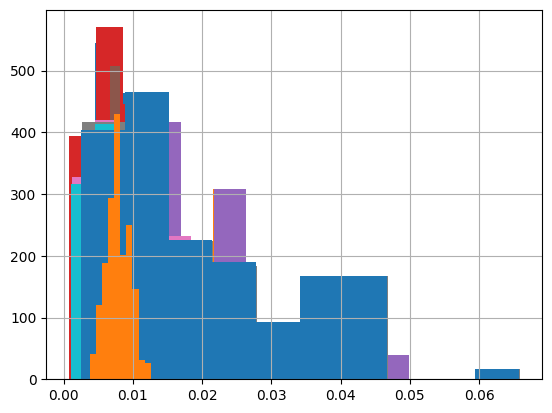

In [ ]:
(abs(cv_results_grouped['tp_sum_cv_min'] - cv_results_grouped['tp_sum_cv_mean']) / cv_results_grouped['tp_sum_cv_mean']).hist()
(abs(cv_results_grouped['fp_sum_cv_min'] - cv_results_grouped['fp_sum_cv_mean']) / cv_results_grouped['fp_sum_cv_mean']).hist()
(abs(cv_results_grouped['fn_sum_cv_min'] - cv_results_grouped['fn_sum_cv_mean']) / cv_results_grouped['fn_sum_cv_mean']).hist()
(abs(cv_results_grouped['tp_mean_cv_min'] - cv_results_grouped['tp_mean_cv_mean']) / cv_results_grouped['tp_mean_cv_mean']).hist()
(abs(cv_results_grouped['fp_mean_cv_min'] - cv_results_grouped['fp_mean_cv_mean']) / cv_results_grouped['fp_mean_cv_mean']).hist()
(abs(cv_results_grouped['fn_mean_cv_min'] - cv_results_grouped['fn_mean_cv_mean']) / cv_results_grouped['fn_mean_cv_mean']).hist()

(abs(cv_results_grouped['tp_sum_cv_max'] - cv_results_grouped['tp_sum_cv_mean']) / cv_results_grouped['tp_sum_cv_mean']).hist()
(abs(cv_results_grouped['fp_sum_cv_max'] - cv_results_grouped['fp_sum_cv_mean']) / cv_results_grouped['fp_sum_cv_mean']).hist()
(abs(cv_results_grouped['fn_sum_cv_max'] - cv_results_grouped['fn_sum_cv_mean']) / cv_results_grouped['fn_sum_cv_mean']).hist()
(abs(cv_results_grouped['tp_mean_cv_max'] - cv_results_grouped['tp_mean_cv_mean']) / cv_results_grouped['tp_mean_cv_mean']).hist()
(abs(cv_results_grouped['fp_mean_cv_max'] - cv_results_grouped['fp_mean_cv_mean']) / cv_results_grouped['fp_mean_cv_mean']).hist()
(abs(cv_results_grouped['fn_mean_cv_max'] - cv_results_grouped['fn_mean_cv_mean']) / cv_results_grouped['fn_mean_cv_mean']).hist()

Выберем оптимальные параметры

In [ ]:
cv_results_grouped.sort_values(by='f1_analog_cv_mean', ascending=False)

,tag_tag_1x1_match_cnt,tag_tag_1x1_match_ratio,token_tag_2x1_match_cnt,token_tag_2x1_match_ratio,token_tag_match_cnt,token_tag_match_ratio,tp_sum_cv_min,tp_sum_cv_max,tp_sum_cv_mean,fp_sum_cv_min,...,fp_mean_cv_mean,fn_mean_cv_min,fn_mean_cv_max,fn_mean_cv_mean,pred_len_cv_min,pred_len_cv_max,pred_len_mean_cv_mean,f1_analog_cv_min,f1_analog_cv_max,f1_analog_cv_mean
1585,5000,0.6,10,0.3,10,0.4,46194,46692,46358.8,63180,...,8.076124,7.536976,7.635578,7.592895,13.897713,14.067471,13.967293,0.428045,0.429981,0.429209
1441,5000,0.5,10,0.3,10,0.4,46194,46692,46359.0,63182,...,8.076276,7.536849,7.635578,7.592869,13.897840,14.067853,13.967471,0.428045,0.429984,0.429208
1009,1000,0.6,10,0.3,10,0.4,46308,46813,46490.6,63643,...,8.143831,7.514612,7.620203,7.576146,13.970902,14.147141,14.051749,0.427969,0.430060,0.429109
1297,5000,0.4,10,0.3,10,0.4,46222,46747,46405.8,63375,...,8.104615,7.530368,7.628590,7.586922,13.925921,14.103050,14.001757,0.427944,0.429881,0.429105
433,10,0.6,10,0.3,10,0.4,46417,46896,46589.0,64049,...,8.201272,7.501017,7.609657,7.563641,14.036341,14.216137,14.121695,0.427698,0.429934,0.428928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,10,0.6,5000,0.6,5000,0.6,1931,2049,2001.6,977,...,0.130026,13.147395,13.315883,13.229705,0.377382,0.395627,0.384386,0.035407,0.037700,0.036683
1655,5000,0.6,1000,0.4,5000,0.6,1931,2049,2001.6,977,...,0.130026,13.147395,13.315883,13.229705,0.377382,0.395627,0.384386,0.035407,0.037700,0.036683
1667,5000,0.6,1000,0.5,5000,0.6,1931,2049,2001.6,977,...,0.130026,13.147395,13.315883,13.229705,0.377382,0.395627,0.384386,0.035407,0.037700,0.036683
1679,5000,0.6,1000,0.6,5000,0.6,1931,2049,2001.6,977,...,0.130026,13.147395,13.315883,13.229705,0.377382,0.395627,0.384386,0.035407,0.037700,0.036683


Выбираем параметры из топа.
Смущает что tag_tag_1x1_match_cnt	и tag_tag_1x1_match_ratio могут принимать слишком разнообразные значения и показатели метрики все равно будут в топе.
Подвигаем их туда-сюда, посмотрим что будет с метрикой.
Смотрим как меняется метрика в зависимости от tag_tag_1x1_match_cnt, видно что несильно но все же чем выше порог match_cnt тем метрика лучше

In [ ]:
cv_results_grouped[
    #(cv_results_grouped['tag_tag_1x1_match_cnt'] == 5000)
    (1==1)
    & (cv_results_grouped['tag_tag_1x1_match_ratio'] == 0.6)
    & (cv_results_grouped['token_tag_2x1_match_cnt'] == 10)
    & (cv_results_grouped['token_tag_2x1_match_ratio'] == 0.3)
    & (cv_results_grouped['token_tag_match_cnt'] == 10)
    & (cv_results_grouped['token_tag_match_ratio'] == 0.4)
][['tag_tag_1x1_match_cnt', 'tp_sum_cv_mean', 'fp_sum_cv_mean', 'fn_sum_cv_mean', 'f1_analog_cv_mean']]

,tag_tag_1x1_match_cnt,tp_sum_cv_mean,fp_sum_cv_mean,fn_sum_cv_mean,f1_analog_cv_mean
433,10,46589.0,64537.4,59519.8,0.428928
1009,1000,46490.6,64085.4,59618.2,0.429109
1585,5000,46358.8,63552.6,59750.0,0.429209


Посмотрим теперь на tag_tag_1x1_match_ratio и метрику. Ситуация схожая.

In [ ]:
cv_results_grouped[
    (cv_results_grouped['tag_tag_1x1_match_cnt'] == 5000)
    # & (cv_results_grouped['tag_tag_1x1_match_ratio'] == 0.6)
    & (cv_results_grouped['token_tag_2x1_match_cnt'] == 10)
    & (cv_results_grouped['token_tag_2x1_match_ratio'] == 0.3)
    & (cv_results_grouped['token_tag_match_cnt'] == 10)
    & (cv_results_grouped['token_tag_match_ratio'] == 0.4)
][['tag_tag_1x1_match_ratio', 'tp_sum_cv_mean', 'fp_sum_cv_mean', 'fn_sum_cv_mean', 'f1_analog_cv_mean']]

,tag_tag_1x1_match_ratio,tp_sum_cv_mean,fp_sum_cv_mean,fn_sum_cv_mean,f1_analog_cv_mean
1153,0.3,47013.2,66443.6,59095.6,0.428239
1297,0.4,46405.8,63776.8,59703.0,0.429105
1441,0.5,46359.0,63553.8,59749.8,0.429208
1585,0.6,46358.8,63552.6,59750.0,0.429209


Посмотрим теперь на tag_tag_1x1_match_ratio с более низким порогом match_cnt.
Результат показывает что лучше порог match_cnt не уменьшать

In [ ]:
cv_results_grouped[
    (cv_results_grouped['tag_tag_1x1_match_cnt'] == 1000)
    # & (cv_results_grouped['tag_tag_1x1_match_ratio'] == 0.6)
    & (cv_results_grouped['token_tag_2x1_match_cnt'] == 10)
    & (cv_results_grouped['token_tag_2x1_match_ratio'] == 0.3)
    & (cv_results_grouped['token_tag_match_cnt'] == 10)
    & (cv_results_grouped['token_tag_match_ratio'] == 0.4)
][['tag_tag_1x1_match_ratio', 'tp_sum_cv_mean', 'fp_sum_cv_mean', 'fn_sum_cv_mean', 'f1_analog_cv_mean']]

,tag_tag_1x1_match_ratio,tp_sum_cv_mean,fp_sum_cv_mean,fn_sum_cv_mean,f1_analog_cv_mean
577,0.3,52323.0,103694.0,53785.8,0.399221
721,0.4,47761.0,70922.4,58347.8,0.424935
865,0.5,46640.8,64731.2,59468.0,0.428919
1009,0.6,46490.6,64085.4,59618.2,0.429109


Определились с tag_tag_1x1_match_cnt и tag_tag_1x1_match_ratio.
Дальше можно просто полюбоваться что выбранные значения параметров оптимальны

In [ ]:
cv_results_grouped[
    (cv_results_grouped['tag_tag_1x1_match_cnt'] == 5000)
    & (cv_results_grouped['tag_tag_1x1_match_ratio'] == 0.6)
    # & (cv_results_grouped['token_tag_2x1_match_cnt'] == 10)
    & (cv_results_grouped['token_tag_2x1_match_ratio'] == 0.3)
    & (cv_results_grouped['token_tag_match_cnt'] == 10)
    & (cv_results_grouped['token_tag_match_ratio'] == 0.4)
][['token_tag_2x1_match_cnt', 'tp_sum_cv_mean', 'fp_sum_cv_mean', 'fn_sum_cv_mean', 'f1_analog_cv_mean']]

,token_tag_2x1_match_cnt,tp_sum_cv_mean,fp_sum_cv_mean,fn_sum_cv_mean,f1_analog_cv_mean
1585,10,46358.8,63552.6,59750.0,0.429209
1633,1000,41223.8,49928.2,64885.0,0.417958
1681,5000,41223.8,49928.2,64885.0,0.417958


In [ ]:
cv_results_grouped[
    (cv_results_grouped['tag_tag_1x1_match_cnt'] == 5000)
    & (cv_results_grouped['tag_tag_1x1_match_ratio'] == 0.6)
    & (cv_results_grouped['token_tag_2x1_match_cnt'] == 10)
    # & (cv_results_grouped['token_tag_2x1_match_ratio'] == 0.3)
    & (cv_results_grouped['token_tag_match_cnt'] == 10)
    & (cv_results_grouped['token_tag_match_ratio'] == 0.4)
][['token_tag_2x1_match_ratio', 'tp_sum_cv_mean', 'fp_sum_cv_mean', 'fn_sum_cv_mean', 'f1_analog_cv_mean']]

,token_tag_2x1_match_ratio,tp_sum_cv_mean,fp_sum_cv_mean,fn_sum_cv_mean,f1_analog_cv_mean
1585,0.3,46358.8,63552.6,59750.0,0.429209
1597,0.4,43692.0,54209.6,62416.8,0.428329
1609,0.5,42440.2,51241.8,63668.6,0.424844
1621,0.6,41961.8,50454.8,64147.0,0.422733


In [ ]:
cv_results_grouped[
    (cv_results_grouped['tag_tag_1x1_match_cnt'] == 5000)
    & (cv_results_grouped['tag_tag_1x1_match_ratio'] == 0.6)
    & (cv_results_grouped['token_tag_2x1_match_cnt'] == 10)
    & (cv_results_grouped['token_tag_2x1_match_ratio'] == 0.3)
    # & (cv_results_grouped['token_tag_match_cnt'] == 10)
    & (cv_results_grouped['token_tag_match_ratio'] == 0.4)
][['token_tag_match_cnt', 'tp_sum_cv_mean', 'fp_sum_cv_mean', 'fn_sum_cv_mean', 'f1_analog_cv_mean']]

,token_tag_match_cnt,tp_sum_cv_mean,fp_sum_cv_mean,fn_sum_cv_mean,f1_analog_cv_mean
1585,10,46358.8,63552.6,59750.0,0.429209
1589,1000,32577.4,37153.2,73531.4,0.370535
1593,5000,30301.6,34886.4,75807.2,0.353788


In [ ]:
cv_results_grouped[
    (cv_results_grouped['tag_tag_1x1_match_cnt'] == 5000)
    & (cv_results_grouped['tag_tag_1x1_match_ratio'] == 0.6)
    & (cv_results_grouped['token_tag_2x1_match_cnt'] == 10)
    & (cv_results_grouped['token_tag_2x1_match_ratio'] == 0.3)
    & (cv_results_grouped['token_tag_match_cnt'] == 10)
    # & (cv_results_grouped['token_tag_match_ratio'] == 0.4)
][['token_tag_match_ratio', 'tp_sum_cv_mean', 'fp_sum_cv_mean', 'fn_sum_cv_mean', 'f1_analog_cv_mean']]

,token_tag_match_ratio,tp_sum_cv_mean,fp_sum_cv_mean,fn_sum_cv_mean,f1_analog_cv_mean
1584,0.3,54311.8,102677.0,51797.0,0.412865
1585,0.4,46358.8,63552.6,59750.0,0.429209
1586,0.5,41756.2,48614.6,64352.6,0.425044
1587,0.6,38373.6,41262.4,67735.2,0.413187


Итак оптимальные параметры модели
```
1. tag_tag_1x1_match_cnt = 5000
2. tag_tag_1x1_match_ratio = 0.6
3. token_tag_2x1_match_cnt = 10
4. token_tag_2x1_match_ratio = 0.3
5. token_tag_match_cnt = 10
6. token_tag_match_ratio = 0.4
```





1. tag_tag_1x1_match_cnt и tag_tag_1x1_match_ratio  и дальше можно двигать вверх (может эта часть модели вообще не нужна)
2. Значения остальных параметров можно уточнять

Посмотрим теперь на теги которые мы в целом предсказываем, в целом не предсказываем и в целом предлагаем ошибочные

Здесь запуск полностью повторяет предыдущий за исключением того что здесь будет только один набор параметров а не сетка и результат работы мы будем сохранять save_result = True

In [ ]:
n_folds = 5

read_match_data_from_dump = 1

train = df.copy()
parts_list = []
for split_iter in range(n_folds - 1):
  split_ratio = (len(df)/n_folds) / len(train)
  train, test = train_test_split(train,test_size=split_ratio,random_state=42)
  parts_list.append(test)
parts_list.append(train)

folds = []
for iter in range(len(parts_list)):
  test = parts_list[iter].copy()
  train = pd.DataFrame()
  for part_id in range(len(parts_list)):
    if part_id != iter:
      if len(train.values) > 0:
        train = pd.concat([train, parts_list[part_id]]).copy()
      else:
        train = parts_list[part_id].copy()
  folds.append((test,train))

del parts_list

if read_match_data_from_dump == 1:
  token_tag_stat_list = [pd.read_csv(f'/content/token_tag_stat_{iter}.csv',
                                     names = ['token',	'tag',	'match_cnt',	'not_match_cnt',	'match_ratio'],
                                     header=0)
                        for iter in range(n_folds)]
  token_tag_2x1_stat_list = [pd.read_csv(f'/content/token_tag_2x1_stat_{iter}.csv',
                                         names = ['token_pair', 'tag', 'match_cnt', 'not_match_cnt', 'match_ratio'],
                                         header=0)
                            for iter in range(n_folds)]
  tag_pairs_stat_list = [pd.read_csv(f'/content/tag_pairs_stat_{iter}.csv',
                                     names = ['tag1', 'tag2', 'match_cnt', 'not_match_cnt', 'match_ratio'],
                                     header=0)
                        for iter in range(n_folds)]

res, result_tags = cv(df,
   folds=n_folds,
   tag_tag_1x1_match_cnt = 5000,
   tag_tag_1x1_match_ratio = 0.6,
   token_tag_2x1_match_cnt = 10,
   token_tag_2x1_match_ratio = 0.3,
   token_tag_match_cnt = 10,
   token_tag_match_ratio = 0.4,
   token_tag_stat_list = token_tag_stat_list,
   token_tag_2x1_stat_list = token_tag_2x1_stat_list,
   tag_pairs_stat_list = tag_pairs_stat_list,
   dump_match_data = False,
   prepared_df_folds = folds,
   save_result = True
   )

In [ ]:
len(result_tags)

5

In [ ]:
for test in result_tags:
  print(len(test))

7870
7870
7870
7870
7866


In [ ]:
result = pd.DataFrame()

In [ ]:
for i in range(len(result_tags)):
  result = pd.concat([result, result_tags[i]]).copy()

In [ ]:
len(result)

39346

In [ ]:
result['app_id'].nunique()

39346

Теги которые мы в целом предсказываем

In [ ]:
tp_tags = result[['app_id','tp_tags']].explode('tp_tags').copy()

In [ ]:
tp_tags.columns = ['app_id', 'tag']

In [ ]:
tp_tags['tag'].nunique()

316

In [ ]:
tp_tags['tag'].unique()

array(['Arcade', '2D', 'Singleplayer', 'Action', 'Multiplayer', 'Shooter',
       'Great Soundtrack', 'Story Rich', 'Visual Novel', 'Anime',
       'Casual', 'Adventure', 'Cute', 'Indie', 'Platformer', 'Puzzle',
       'Relaxing', 'Time Management', 'Simulation', 'Replay Value',
       'Point & Click', 'Text-Based', 'Strategy', 'Family Friendly',
       'Choices Matter', 'Trivia', 'VR', 'RPG', 'Utilities', 'Military',
       'War', 'Sci-fi', 'Open World', 'Early Access', 'Physics',
       'Sandbox', 'Space', 'Bullet Hell', 'Education', "Shoot 'Em Up",
       'Difficult', 'Historical', 'World War II', 'Wargame', 'Zombies',
       'Action RPG', 'Fantasy', 'Hack and Slash', 'Retro',
       '2D Platformer', 'Pixel Graphics', 'First-Person', 'Survival',
       'Atmospheric', 'Dating Sim', 'Racing', 'Horror', 'Mystery',
       'Roguelike', 'Runner', 'Romance', 'Detective', 'Local Multiplayer',
       'Post-apocalyptic', '3D', 'Dark', 'Tower Defense', 'Flight',
       'Management', nan, 'Mech

In [ ]:
tp_tags_list = list(tp_tags['tag'].unique())

Теги которые мы в целом предсказываем ошибочно

In [ ]:
fp_tags = result[['app_id','fp_tags']].explode('fp_tags').copy()

In [ ]:
fp_tags.columns = ['app_id', 'tag']

In [ ]:
fp_tags['tag'].nunique()

315

Сколько раз на всем множестве тег был предсказан ошибочно

In [ ]:
fp_tags.groupby('tag')['app_id'].count().sort_values(ascending=False).head(20)

tag
Casual          22855
Adventure       21749
Action          21622
Singleplayer    18218
Simulation      15680
Strategy        15623
2D              15210
Indie           14947
RPG             12148
Story Rich       8879
Atmospheric      8563
Multiplayer      8522
Puzzle           8143
Fantasy          4492
Horror           4208
Anime            3742
Exploration      3521
First-Person     3199
Cute             3176
Shooter          3130
Name: app_id, dtype: int64

In [ ]:
fp_tags['tag'].unique()

array(['Retro', 'Platformer', 'Casual', 'Local Co-Op', 'Indie', 'RPG',
       'Adventure', 'Side Scroller', 'Co-op', 'Comedy', 'Funny',
       'Simulation', 'Music', 'Action', 'Building', 'Multiplayer',
       'Sandbox', 'Strategy', '2D', 'Singleplayer', 'Shooter', 'Tanks',
       'Cats', '1980s', "1990's", 'Word Game', 'Logic', 'Story Rich',
       'Comic Book', 'Ninja', 'Puzzle', 'Atmospheric', 'Superhero',
       'Point & Click', 'Historical', 'First-Person', 'Realistic', 'VR',
       'Management', '3D', 'Exploration', 'Sports', "Shoot 'Em Up",
       'Family Friendly', 'Trivia', 'Roguelite', 'Fantasy',
       'Pixel Graphics', 'Magic', 'Anime', 'Sci-fi', 'Action Roguelike',
       'Survival', 'Bullet Hell', 'Difficult', 'Horror',
       'Psychological Horror', 'Dark', 'Visual Novel', 'Open World',
       'Game Development', 'Hidden Object', 'Turn-Based',
       'Turn-Based Strategy', 'Dungeon Crawler', 'Turn-Based Tactics',
       'Turn-Based Combat', 'Procedural Generation', 'Earl

In [ ]:
fp_tags_list = list(fp_tags['tag'].unique())

Теги которые мы в целом не угадываем

In [ ]:
fn_tags = result[['app_id','fn_tags']].explode('fn_tags').copy()

In [ ]:
fn_tags.columns = ['app_id', 'tag']

In [ ]:
fn_tags['tag'].nunique()

439

Сколько раз на всем множестве тег был не угадан

In [ ]:
fn_tags.groupby('tag')['app_id'].count().sort_values(ascending=False).head(20)

tag
3D                    4908
Colorful              4461
Pixel Graphics        4080
Funny                 3899
Atmospheric           3884
Early Access          3842
Great Soundtrack      3650
Free to Play          3557
Exploration           3531
Difficult             3497
Cute                  3471
Family Friendly       3261
2D                    3060
Retro                 3020
Female Protagonist    2995
First-Person          2977
Action-Adventure      2823
Third Person          2775
Stylized              2588
Comedy                2579
Name: app_id, dtype: int64

In [ ]:
fn_tags['tag'].unique()

array(['Satire', 'Military', 'Philosophical', '2D Platformer',
       "Shoot 'Em Up", 'Futuristic', 'War', 'Space', 'Horror',
       'Female Protagonist', 'Psychological Horror', 'Atmospheric',
       'Mystery', 'Dark', nan, 'Great Soundtrack', 'Cartoon', 'Beautiful',
       'Arcade', 'Short', 'Puzzle Platformer', 'Linear', 'Minimalist',
       'Soundtrack', 'Colorful', 'Family Friendly', 'Controller',
       'Sports', 'Early Access', 'Animation & Modeling',
       'Design & Illustration', 'Massively Multiplayer', 'FPS',
       'Simulation', 'World War II', 'Violent', 'Gore', 'Mod',
       'Free to Play', 'Space Sim', 'Building', 'Time Manipulation',
       'Stylized', 'Pinball', 'Cyberpunk', 'Fast-Paced', 'Classic',
       'Procedural Generation', 'Touch-Friendly', 'Bullet Time',
       'Old School', 'Score Attack', 'Addictive', 'Story Rich', 'Retro',
       'Funny', 'Point & Click', 'Cult Classic', '2.5D', 'Drama',
       'Mouse only', 'Based On A Novel', 'Puzzle', 'Exploration',
   

In [ ]:
fn_tags_list = list(fn_tags['tag'].unique())

Множества тегов которые мы в целом угадываем и которые предлагаем ошибочно в целом похожи сильно. Интуитивно в этом ничего удивительного исходя из алгоритма работы модели.

In [ ]:
set(tp_tags_list) - set(fp_tags_list)

{'FMV', 'Software Training', 'Souls-like'}

In [ ]:
set(fp_tags_list) - set(tp_tags_list)

{'Benchmark', 'Narration'}

Множества тегов которые мы в целом угадываем и не угадываем различаются существенно.

In [ ]:
set(tp_tags_list) - set(fn_tags_list)

{'Cricket', 'Rugby'}

In [ ]:
set(fn_tags_list) - set(tp_tags_list)

{'360 Video',
 '3D Fighter',
 '3D Vision',
 '6DOF',
 '8-bit Music',
 'ATV',
 'Action RTS',
 'Addictive',
 'Alternate History',
 'Ambient',
 'America',
 'Asymmetric VR',
 'Asynchronous Multiplayer',
 'BMX',
 'Based On A Novel',
 'Beautiful',
 'Benchmark',
 'Blood',
 'Boss Rush',
 'Bullet Time',
 'Capitalism',
 'Character Action Game',
 'Cinematic',
 'Class-Based',
 'Co-op Campaign',
 'Coding',
 'Collectathon',
 'Combat Racing',
 'Conspiracy',
 'Conversation',
 'Cozy',
 'Crowdfunded',
 'Cult Classic',
 'Cycling',
 'Dark Comedy',
 'Dark Humor',
 'Demons',
 'Diplomacy',
 'Documentary',
 'Dragons',
 'Dynamic Narration',
 'Electronic',
 'Electronic Music',
 'Epic',
 'Episodic',
 'Experience',
 'Experimental',
 'Farming',
 'Feature Film',
 'Foreign',
 'Fox',
 'GameMaker',
 'Gaming',
 'God Game',
 'Gun Customization',
 'Hardware',
 'Hero Shooter',
 'Hobby Sim',
 'Hunting',
 'Illuminati',
 'Immersive',
 'Immersive Sim',
 'Instrumental Music',
 'Intentionally Awkward Controls',
 'Inventory Manag

Множества тегов которые мы в целом предлагаем ошибочно и не угадываем различаются существенно.

In [ ]:
set(fn_tags_list) - set(fp_tags_list)

{'360 Video',
 '3D Fighter',
 '3D Vision',
 '6DOF',
 '8-bit Music',
 'ATV',
 'Action RTS',
 'Addictive',
 'Alternate History',
 'Ambient',
 'America',
 'Asymmetric VR',
 'Asynchronous Multiplayer',
 'BMX',
 'Based On A Novel',
 'Beautiful',
 'Blood',
 'Boss Rush',
 'Bullet Time',
 'Capitalism',
 'Character Action Game',
 'Cinematic',
 'Class-Based',
 'Co-op Campaign',
 'Coding',
 'Collectathon',
 'Combat Racing',
 'Conspiracy',
 'Conversation',
 'Cozy',
 'Crowdfunded',
 'Cult Classic',
 'Cycling',
 'Dark Comedy',
 'Dark Humor',
 'Demons',
 'Diplomacy',
 'Documentary',
 'Dragons',
 'Dynamic Narration',
 'Electronic',
 'Electronic Music',
 'Epic',
 'Episodic',
 'Experience',
 'Experimental',
 'FMV',
 'Farming',
 'Feature Film',
 'Foreign',
 'Fox',
 'GameMaker',
 'Gaming',
 'God Game',
 'Gun Customization',
 'Hardware',
 'Hero Shooter',
 'Hobby Sim',
 'Hunting',
 'Illuminati',
 'Immersive',
 'Immersive Sim',
 'Instrumental Music',
 'Intentionally Awkward Controls',
 'Inventory Management'

In [ ]:
set(fp_tags_list) - set(fn_tags_list)

{'Cricket', 'Rugby'}

Сравним с бейслайном.
Принцип построения бейслайна сделаем - простой рандом на основе вероятности появления тега у игры на трейне

In [ ]:
train, test = train_test_split(df,test_size=0.8,random_state=42)

In [ ]:
train = train[['app_id', 'tags']].explode('tags').copy()

In [ ]:
train.columns = ['app_id', 'tag']

In [ ]:
tag_stat = train.groupby('tag')['app_id'].count().reset_index()

In [ ]:
tag_stat.columns = ['tag', 'app_cnt']

In [ ]:
tag_stat['proba'] = tag_stat['app_cnt'] / len(train)

In [ ]:
tag_stat

,tag,app_cnt,proba
0,1980s,156,0.001470
1,1990's,241,0.002271
2,2.5D,178,0.001677
3,2D,2196,0.020692
4,2D Fighter,93,0.000876
...,...,...,...
434,World War I,24,0.000226
435,World War II,112,0.001055
436,Wrestling,8,0.000075
437,Zombies,245,0.002309


In [ ]:
from numpy import random

In [ ]:
# фукнция пробегается по всему множеству тегов и на основе вероятности наличия тега у игры на трейне выдает тег или не выдает
# и так для каждого тега
def apply_tags (row, **kwargs):

  tag_stat = kwargs['tag_stat']
  tag_stat = list(tag_stat[['tag', 'proba']].values)
  tag_probas = {}

  for stat in tag_stat:
    tag_probas[stat[0]] = stat[1]

  result_tag_list = []
  for tag in tag_probas:
    tag_proba = random.binomial(n=1, p=tag_probas[tag])
    if tag_proba == 1:
      result_tag_list.append(tag)

  return result_tag_list

In [ ]:
test['pred_tags'] = test.apply(apply_tags,tag_stat=tag_stat, axis=1)

In [ ]:
test['tp'] = [len(set(pred_tags).intersection(set(tags)))
for (pred_tags, tags) in list(test[['pred_tags','tags']].values)]

test['fp'] = [len(set(pred_tags) - set(tags))
for (pred_tags, tags) in list(test[['pred_tags','tags']].values)]

test['fn'] = [len(set(tags) - set(pred_tags))
for (pred_tags, tags) in list(test[['pred_tags','tags']].values)]

test['pred_len'] = [len(pred_tag_list)
for pred_tag_list in list(test['pred_tags'].values)]

In [ ]:
tp_sum = test['tp'].sum()
fp_sum = test['fp'].sum()
fn_sum = test['fn'].sum()
tp_mean = test['tp'].mean()
fp_mean = test['fp'].mean()
fn_mean = test['fn'].mean()
pred_len_mean = test['pred_len'].mean()

Наша модель очевидно лучше этого безобразия

In [ ]:
print(tp_sum, fp_sum, fn_sum, tp_mean, fp_mean, fn_mean, pred_len_mean)

4906 26689 419513 0.15585983416462815 0.8478889347777743 13.32760428249198 1.0037487689424023
